In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from IPython.core.display import display, HTML, clear_output
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection
from scipy.stats import sem, ttest_ind, f_oneway, kruskal

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [5]:
sys.path.append("../")
import plotting as my_plot

sys.path.append("./mean_field_elect/")
import proteomics_functions as prot_fun
import base_classes
import morbidelli as m

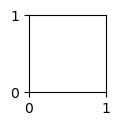

In [6]:
fig, ax = my_plot.instantiate_fig(1, 1)

# Load data

In [8]:
df_sec = pd.read_csv('./generated_tables/prev_swath_master_df_ppm.csv')
df_swath = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')

df_all = df_sec.merge(df_swath, how='outer')
df_all = df_all.fillna(0)

df_plot = df_all.drop(columns=['accn', 'name'])
df_plot = df_plot.fillna(0)
df_plot = np.log10(df_plot)
df_plot.replace(-1*np.inf, np.nan, inplace=True)

/home/chase/psi4conda/envs/jupyter/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [9]:
df_fn = df_all[((df_all.cq_a5 > 0.0) | (df_all.cq_b12 > 0.0) | (df_all.cq_d9 > 0.0) | (df_all.cq_g12 > 0.0) | 
                (df_all.xq_a5 > 0.0) | (df_all.xq_b12 > 0.0) | (df_all.xq_d9 > 0.0) | (df_all.xq_g12 > 0.0) | 
                (df_all.hq_a5 > 0.0) | (df_all.hq_b12 > 0.0) | (df_all.hq_d9 > 0.0) | (df_all.hq_g12 > 0.0)) & (df_all.pavin_feed == 0.0)].copy()

df_den = df_all[((df_all.cq_a5 > 0.0) | (df_all.cq_b12 > 0.0) | (df_all.cq_d9 > 0.0) | (df_all.cq_g12 > 0.0) | 
                 (df_all.xq_a5 > 0.0) | (df_all.xq_b12 > 0.0) | (df_all.xq_d9 > 0.0) | (df_all.xq_g12 > 0.0) | 
                 (df_all.hq_a5 > 0.0) | (df_all.hq_b12 > 0.0) | (df_all.hq_d9 > 0.0) | (df_all.hq_g12 > 0.0))].copy()

In [10]:
len(df_fn), len(df_den)

(69, 321)

In [11]:
df_fn_eluate = df_all[((df_all.cq_eluate > 0.0) | (df_all.hq_eluate > 0.0) | (df_all.xq_eluate > 0.0)) & 
                      ((df_all.pavin_feed == 0.0) & (df_all.pavin_large == 0.0) & (df_all.pavin_small == 0.0) & (df_all.pavin_mab == 0.0))].copy()

df_den_eluate = df_all[((df_all.cq_eluate > 0.0) | (df_all.hq_eluate > 0.0) | (df_all.xq_eluate > 0.0))].copy()

In [12]:
len(df_fn_eluate), len(df_den_eluate)

(47, 1228)

In [13]:
len(df_swath[df_swath.cq_eluate > 0.0]), len(df_swath[df_swath.xq_eluate > 0.0]), len(df_swath[df_swath.hq_eluate > 0.0])

(492, 657, 1173)

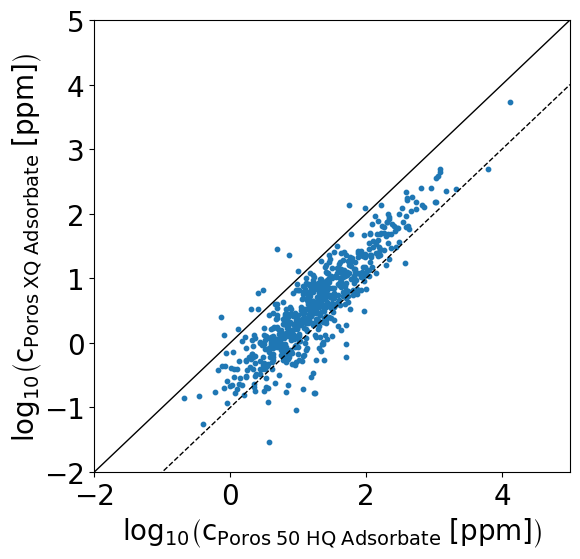

In [14]:
fig, ax = my_plot.instantiate_fig(xlabel=r'$\mathsf{log_{10}\left( c_{Poros \; 50 \; HQ \; Adsorbate} \; [ppm] \right)}$', 
                                  ylabel=r'$\mathsf{log_{10}\left( c_{Poros \; XQ \; Adsorbate} \; [ppm] \right)}$', x=6.2, y=6)

ax.scatter(df_plot.hq_eluate, df_plot.xq_eluate, label='CQ G12', s=10)

vals = np.array([-2, 5])
ax.set_xlim(vals)
ax.set_ylim(vals)
ax.plot(vals, vals, color='black', linewidth=1)
ax.plot(vals, vals-1, color='black', linewidth=1, linestyle='--')

my_plot.set_layout(fig, ax)
# plt.savefig('./images/12_xq_vs_hq_adsorbate.png', dpi=300)

In [35]:
df_xq_unique = df_swath[(df_swath.xq_eluate > 0.0) & (df_swath.hq_eluate == 0.0)].copy()

In [38]:
len(df_xq_unique), len(df_swath)

(39, 1249)

In [39]:
len(df_swath[(df_swath.xq_eluate > 0.0) | (df_swath.hq_eluate > 0.0)])

1212

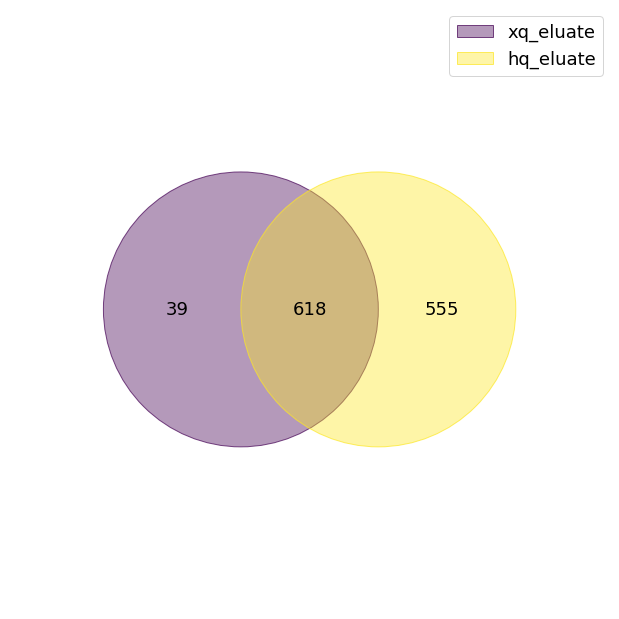

In [45]:
sets = Dict()
for sample in ['xq_eluate', 'hq_eluate']:
    sets[sample] = set(df_swath[df_swath[sample] > 0.0].accn)
    
fig, ax = my_plot.instantiate_fig(9, 9)
venn(sets, ax=ax, fontsize=18)
my_plot.set_layout(fig, ax)
fig.savefig('./images/12_venn_xq_vs_hq_adsorbate.png', dpi=300)

In [49]:
df = pd.read_csv('./generated_tables/swath_master_df_ppm_with_properties.csv')

df_xq_unique = df[(df.xq_eluate > 0.0) & (df.hq_eluate == 0.0)].copy()
df_hq_unique = df[(df.xq_eluate == 0.0) & (df.hq_eluate > 0.0)].copy()
df_inter = df[(df.xq_eluate > 0.0) & (df.hq_eluate > 0.0)].copy()

In [55]:
groups = ['Poros XQ Adsorbate' for _ in range(len(df_xq_unique))] + ['Intersection' for _ in range(len(df_inter))] + ['Poros 50 HQ Adsorbate' for _ in range(len(df_hq_unique))]
masses = list(df_xq_unique.mass) + list(df_inter.mass) + list(df_hq_unique.mass)
masses = np.array(masses) * 1e-3
iso_pts = list(df_xq_unique.pI) + list(df_inter.pI) + list(df_hq_unique.pI)

df_plot_mass = pd.DataFrame({'group':groups, 'Molecular mass [kDa]':masses})
df_plot_pI = pd.DataFrame({'group':groups, 'Isoelectric point':iso_pts})

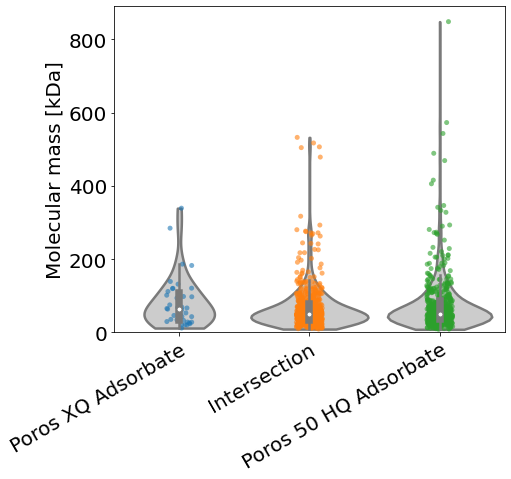

In [59]:
plt.gcf().set_size_inches(7, 6)

prop = 'Molecular mass [kDa]'
ax = sns.violinplot(x="group", y=prop, data=df_plot_mass, color=".8", linewidth=2.5, width=0.9, cut=0)

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x="group", y=prop, data=df_plot_mass, jitter=True, ax=ax, alpha=0.6)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ax.set_ylim(0, None)
plt.savefig('./images/12_violin_mass.png', dpi=300, bbox_inches='tight')

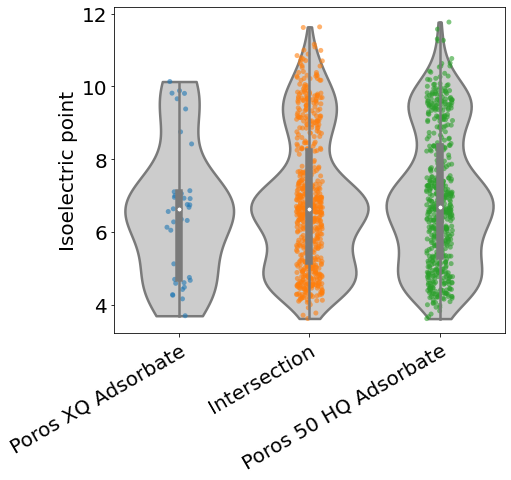

In [63]:
plt.gcf().set_size_inches(7, 6)

prop = 'Isoelectric point'
my_df = df_plot_pI
ax = sns.violinplot(x="group", y=prop, data=my_df, color=".8", linewidth=2.5, width=0.9, cut=0)

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x="group", y=prop, data=my_df, jitter=True, ax=ax, alpha=0.6)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
plt.savefig('./images/12_violin_pI.png', dpi=300, bbox_inches='tight')

In [66]:
f_oneway(*[list(df_xq_unique.mass), list(df_inter.mass), list(df_hq_unique.mass)])

F_onewayResult(statistic=2.2556613477761362, pvalue=0.10524510201359226)

In [67]:
f_oneway(*[list(df_xq_unique.pI), list(df_inter.pI), list(df_hq_unique.pI)])

F_onewayResult(statistic=0.8308199471608836, pvalue=0.4359404909408561)

In [9]:
df_num = df_all[((df_all.hccf_large > 0.0) | (df_all.hccf_small > 0.0) | (df_all.hccf_mab > 0.0) | (df_all.hccf_spf1 > 0.0) | (df_all.hccf_spf2 > 0.0)) &
                 (df_all.hccf_feed == 0.0)].copy()

df_den = df_all[(df_all.hccf_large > 0.0) | (df_all.hccf_small > 0.0) | (df_all.hccf_mab > 0.0) | (df_all.hccf_spf1 > 0.0) | (df_all.hccf_spf2 > 0.0) |
                 (df_all.hccf_feed > 0.0)].copy()

len(df_num), len(df_den)

(1278, 2409)

In [11]:
df_num = df_all[((df_all.pavin_large > 0.0) | (df_all.pavin_small > 0.0) | (df_all.pavin_mab > 0.0)) & (df_all.pavin_feed == 0.0)].copy()

df_den = df_all[(df_all.pavin_large > 0.0) | (df_all.pavin_small > 0.0) | (df_all.pavin_mab > 0.0) | (df_all.pavin_feed > 0.0)].copy()


len(df_num), len(df_den)

(1551, 1899)